In [4]:
# import packages
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import foldnorm
from uncertainty_toolbox import metrics_calibration

import matplotlib.pyplot as plt
import matplotlib
# fix numpy seed for reproducibility

import scipy as sp

In [5]:
import torch

def NLL(input: torch.Tensor, target: torch.Tensor, var: torch.Tensor, full=True, eps=1e-06):
    return torch.nn.functional.gaussian_nll_loss(input.flatten(), target.flatten(), var.flatten(), full=full,eps=eps)

def RMSE(input, target):
    return torch.sqrt(torch.mean((input.flatten() - target.flatten())**2))

def MSE(input, target):
    return torch.mean((input.flatten() - target.flatten())**2)

def get_coeff(input: torch.Tensor, target: torch.Tensor, var: torch.Tensor) -> torch.tensor:
    """ Returns dimensionless NLL coefficient
    """
    #print(input.shape)
    #print(target.shape)
    #print(var.shape)
    
    mse = MSE(input,target)
    uncertainty_estimate = (input.flatten() - target.flatten())**2
    
    LL_best = torch.nn.functional.gaussian_nll_loss(input.flatten(), target.flatten(), uncertainty_estimate.flatten(), full=False, eps=0.)
    
    LL_worst_case_best_RMSE = torch.nn.functional.gaussian_nll_loss\
        (input.flatten(), target.flatten(), torch.ones_like(var.flatten())*mse, full=False, eps=0.)
    
    LL_actual = torch.nn.functional.gaussian_nll_loss(input.flatten(), target.flatten(), var.flatten(), full=False, eps=0.)
    
    coeff = 1/( LL_best - LL_worst_case_best_RMSE) * (LL_actual - LL_worst_case_best_RMSE) * 100

    return coeff

def get_z_score_variance(input: torch.tensor, target: torch.tensor, var_pred: torch.tensor):

    z = (target.flatten() - input.flatten()) / torch.sqrt(var_pred.flatten())

    return torch.var(z)



In [7]:
ROUND_DIGITS = 1
plt.rcParams.update({'font.size': 11.0})
matplotlib.rc('xtick', labelsize=10.0) 
matplotlib.rc('ytick', labelsize=10.0) 
plt.rc('axes', labelsize=12.)

QUANTILE_ALPHA = 0.5
QUANTILE_ALPHA_UNIT = 0.8
SCATTER_ALPHA = 0.25

/var/folders/7y/yhl65v0j5m3g8zj_xwkzq44w0000gn/T/ipykernel_33839/932968458.py:387: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.25)


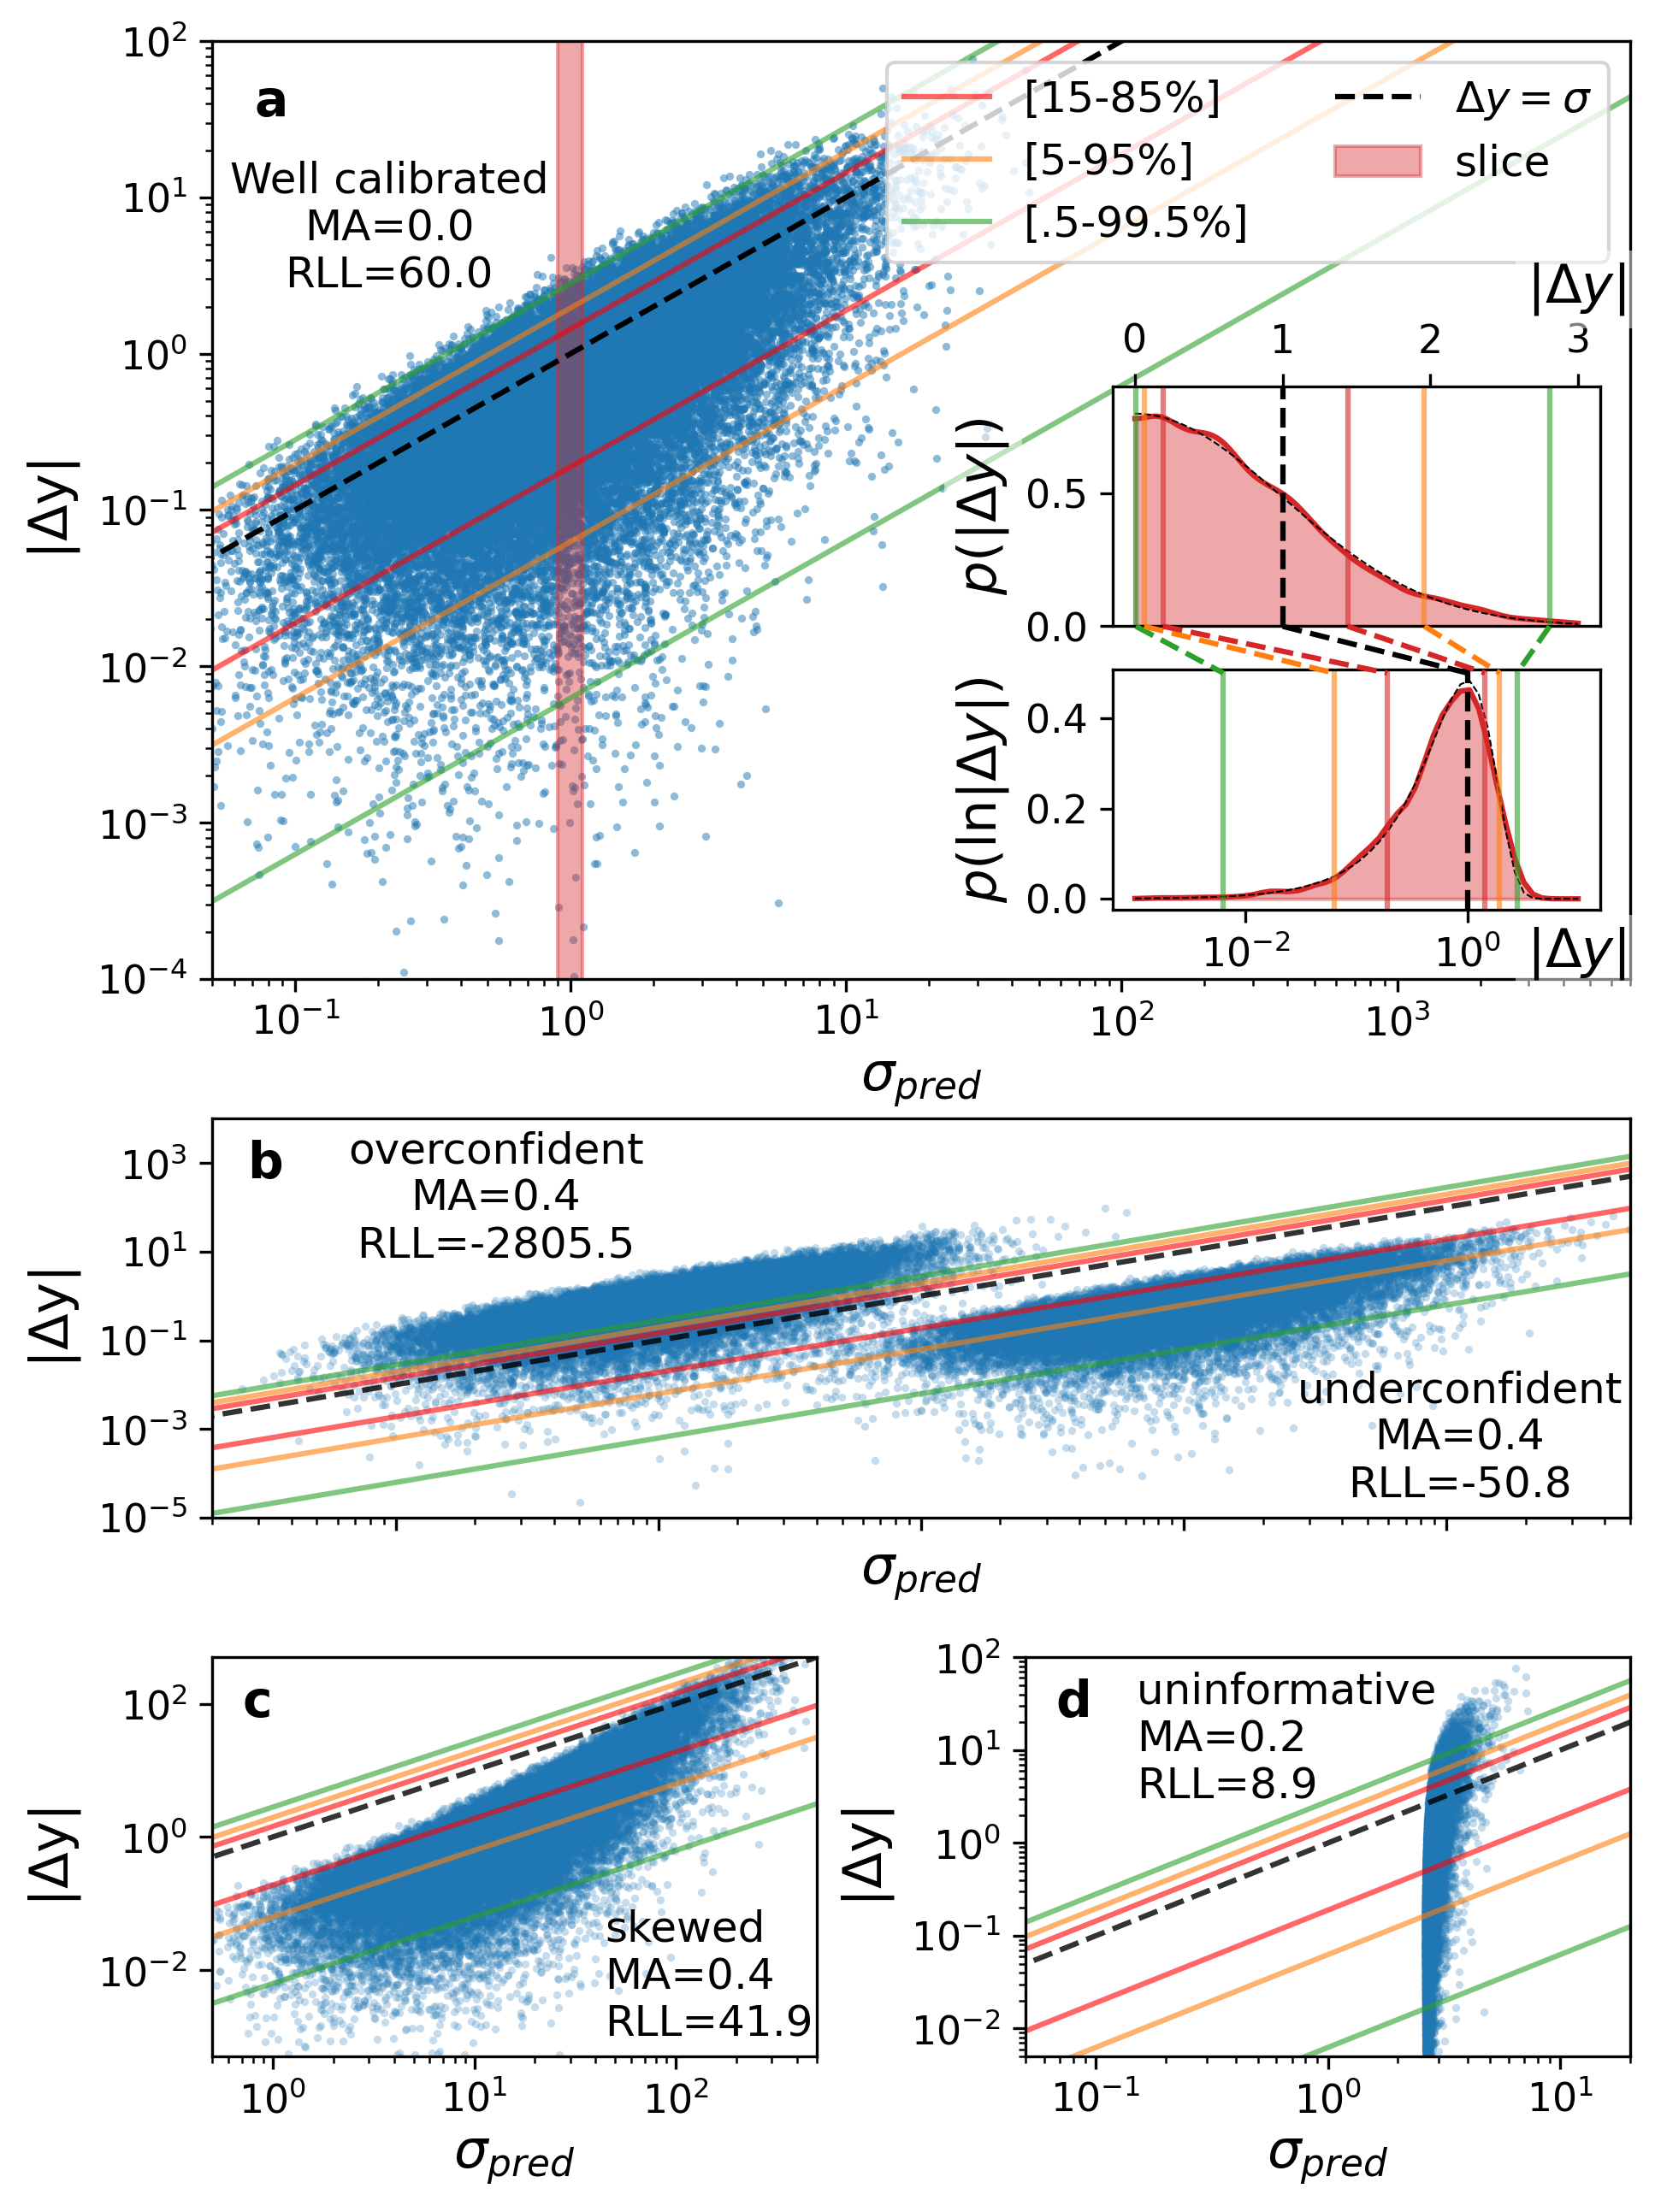

In [216]:
ROUND_DIGITS = 1
plt.rcParams.update({'font.size': 11.0})
matplotlib.rc('xtick', labelsize=11.0) 
matplotlib.rc('ytick', labelsize=11.0) 
plt.rc('axes', labelsize=15.)

QUANTILE_ALPHA = 0.6
QUANTILE_ALPHA_UNIT = 0.8
SCATTER_ALPHA = 0.25

TEXT_CAPTION = 12
LETTER_CAPTION = 14

POINTS = 50000
np.random.seed(0)

#generate the grid points
#x = np.logspace(-1.,1,POINTS)

x = np.random.lognormal(mean=0.0, sigma=1.0, size=50000)
y = np.zeros(POINTS)

#generate the noise/targets
#noise level is the perfect uncertainty estimate 

noise_level = np.abs(x) * 1
noise_hetero = np.random.normal(y,noise_level,POINTS) 

#generate residuals
z = np.abs(y-(y+noise_hetero))


#generate the quantile lines by evaluating the folded normal distribution
# quantile distribution

x_2 = np.logspace(-5.,5.,10)
noise_level_2 = np.abs(x_2)
quantiles_lower_01 = [foldnorm.ppf(0.15, 0.,0.,i) for i in noise_level_2]
quantiles_upper_01 = [foldnorm.ppf(0.85, 0.,0.,i) for i in noise_level_2]
quantiles_lower_05 = [foldnorm.ppf(0.05, 0.,0.,i) for i in noise_level_2]
quantiles_upper_05 = [foldnorm.ppf(0.95, 0.,0.,i) for i in noise_level_2]
quantiles_lower_005 = [foldnorm.ppf(0.005, 0.,0.,i) for i in noise_level_2]
quantiles_upper_005 = [foldnorm.ppf(0.995, 0.,0.,i) for i in noise_level_2]

fig = plt.figure(figsize=(9.5, 8.5), dpi=300)
spec = fig.add_gridspec(8, 3)


ax0 = fig.add_subplot(spec[4:6, :2])
ax10 = fig.add_subplot(spec[6:8, 0])
ax11 = fig.add_subplot(spec[6:8, 1])

axexplain  = fig.add_subplot(spec[:4, :2])
axtoy = fig.add_axes([0.45, 0.72, 0.2, 0.11])

axtoy2 = fig.add_axes([0.45, 0.59, 0.2, 0.11])
#axtoy2 = fig.add_subplot(spec[1, 1])
ax0.tick_params(labelbottom=False)

axexplain.scatter(noise_level, z, s=5., color="tab:blue", alpha=0.5, rasterized=True, linewidth=0.)

axexplain.plot(noise_level_2, quantiles_upper_01, color = "red", label="[15-85%]", alpha=QUANTILE_ALPHA, rasterized=True)
axexplain.plot(noise_level_2, quantiles_lower_01, color = "red", alpha=QUANTILE_ALPHA, rasterized=True)

axexplain.plot(noise_level_2, quantiles_lower_05, color = "tab:orange", label="[5-95%]", alpha=QUANTILE_ALPHA, rasterized=True)
axexplain.plot(noise_level_2, quantiles_upper_05, color = "tab:orange", alpha=QUANTILE_ALPHA, rasterized=True)

axexplain.plot(noise_level_2, quantiles_lower_005, color = "tab:green", label="[.5-99.5%]", alpha=QUANTILE_ALPHA, rasterized=True)
axexplain.plot(noise_level_2, quantiles_upper_005, color = "tab:green", alpha=QUANTILE_ALPHA, rasterized=True)

axexplain.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", rasterized=True, label=r"$\Delta y=\sigma$")

max_slice = 1.1
min_slice = 0.9

"""
axexplain.text(1.02, 0.96, "99.5%", color="tab:green", fontsize=7, transform=axexplain.transAxes, rasterized=True)
axexplain.text(1.02, 0.92, "95%", color="tab:orange", fontsize=7, transform=axexplain.transAxes, rasterized=True)
axexplain.text(1.02, 0.88, "85%", color="tab:red", fontsize=7, transform=axexplain.transAxes, rasterized=True)
axexplain.text(1.02, 0.76, "15%", color="tab:red", fontsize=7, transform=axexplain.transAxes, rasterized=True)
axexplain.text(1.02, 0.68, "5%", color="tab:orange", fontsize=7, transform=axexplain.transAxes, rasterized=True)
axexplain.text(1.02, 0.5, "0.5%", color="tab:green", fontsize=7, transform=axexplain.transAxes, rasterized=True)
"""

ymin, ymax = axexplain.get_ylim()
axexplain.fill_betweenx([ymin, ymax], min_slice, max_slice, color='tab:red', alpha=0.4, label="slice")
#axexplain.fill_betweenx([ymin, ymax], min_slice, max_slice, color='grey', alpha=0.2, label="slice")
#axexplain.axvline(min_slice, color="grey", linestyle="--", rasterized=True)
#axexplain.axvline(max_slice, color="grey", linestyle="--", rasterized=True)


real_z = z[(noise_level > min_slice) & (noise_level < max_slice)]

kd = sp.stats.gaussian_kde(real_z)
dy = np.linspace(0,3,1000)

#axtoy.hist(real_z, bins=30, color="tab:blue", alpha=0.5, label="slice for b)")
axtoy.plot(dy, (kd(dy)+kd(-dy)), 'tab:red', label="empirical")
#fill the area under the curve
axtoy.fill_between(dy, 0, (kd(dy)+kd(-dy)), color='tab:red', alpha=0.4)

axtoy.plot(dy, 2*np.exp(-dy**2/2)/np.sqrt(2*np.pi), 
              'k--', lw=0.5, label=r"fold. $\mathcal{N}$")

axtoy.axvline(1, color="black", linestyle="--", rasterized=True,)
axtoy.axvline(sp.special.erfinv(0.15)*np.sqrt(2), color="tab:red", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy.axvline(sp.special.erfinv(0.85)*np.sqrt(2), color="tab:red", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy.axvline(sp.special.erfinv(0.05)*np.sqrt(2), color="tab:orange", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy.axvline(sp.special.erfinv(0.95)*np.sqrt(2), color="tab:orange", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy.axvline(sp.special.erfinv(0.005)*np.sqrt(2), color="tab:green", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy.axvline(sp.special.erfinv(0.995)*np.sqrt(2), color="tab:green", rasterized=True, alpha=QUANTILE_ALPHA)

#axtoy.legend(fontsize=7.5)

axtoy.xaxis.set_ticks_position('top')
axtoy.xaxis.set_label_position('top')



lkd = sp.stats.gaussian_kde(np.log(real_z))
dy = np.geomspace(1e-3,10)
ldy = np.log(dy)

axtoy2.semilogx(dy, lkd(ldy), 'tab:red')
axtoy2.plot(dy, 2*dy*np.exp(-dy**2/2)/np.sqrt(2*np.pi), 
              'k--', lw=0.5)

# fill the area under the curve
axtoy2.fill_between(dy, 0, lkd(ldy), color='tab:red', alpha=0.4)

#axtoy2.set_xlim(3e-2, 7000)

quantile_vals = sp.special.erfinv([0.005,0.05,0.15,0.5,0.85,0.95,0.995])*np.sqrt(2)

axtoy.set_ylim(0,0.9)

axtoy2.axvline(1, color="black", linestyle="--", rasterized=True)
axtoy2.axvline(sp.special.erfinv(0.15)*np.sqrt(2), color="tab:red", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy2.axvline(sp.special.erfinv(0.85)*np.sqrt(2), color="tab:red", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy2.axvline(sp.special.erfinv(0.05)*np.sqrt(2), color="tab:orange", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy2.axvline(sp.special.erfinv(0.95)*np.sqrt(2), color="tab:orange", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy2.axvline(sp.special.erfinv(0.005)*np.sqrt(2), color="tab:green", rasterized=True, alpha=QUANTILE_ALPHA)
axtoy2.axvline(sp.special.erfinv(0.995)*np.sqrt(2), color="tab:green", rasterized=True, alpha=QUANTILE_ALPHA)

axtoy.set_ylabel(r"$p(|\Delta y|)$", bbox=dict(facecolor='white', edgecolor='none', pad=3, alpha=0.5))
axtoy.set_xlabel(r"$|\Delta y|$", bbox=dict(facecolor='white', edgecolor='none', pad=3, alpha=0.5))
axtoy2.set_xlabel(r"$|\Delta y|$", bbox=dict(facecolor='white', edgecolor='none', pad=3, alpha=0.5))
axtoy2.set_ylabel(r"$p(\ln|\Delta y|)$", bbox=dict(facecolor='white', edgecolor='none', pad=3, alpha=0.5))

axtoy.xaxis.set_label_coords(0.95, 1.35)  # x and y coordinates in axes fraction
axtoy2.xaxis.set_label_coords(0.95, -0.065)

iso = sp.special.erfinv([0.005,0.05,0.15,0.5,0.85,0.95,0.995])*np.sqrt(2)

iso[3] = 1
colors = ["tab:green","tab:orange", "tab:red", "k",   "tab:red", "tab:orange", "tab:green",]

LINEWIDTH_TOY = axtoy.lines[0].get_linewidth()

for x_c, c in zip(iso, colors): 
    coord_top = axtoy.transData.transform((x_c, 0))
    coord_bottom = axtoy2.transData.transform((x_c, 0.5))
    # Transform display coordinates to figure coordinates
    coord_top_fig = fig.transFigure.inverted().transform(coord_top)
    coord_bottom_fig = fig.transFigure.inverted().transform(coord_bottom)    

    line = plt.Line2D(
        [coord_top_fig[0], coord_bottom_fig[0]],
        [coord_top_fig[1], coord_bottom_fig[1]],
        transform=fig.transFigure, color=c, linestyle='--', lw=LINEWIDTH_TOY
    )
    fig.add_artist(line)




axexplain.loglog()
axexplain.set_xlim(0.05,7000)
axexplain.set_ylim(1e-04,1e02)
axexplain.set_ylabel(r"|$\Delta$y|")
axexplain.set_xlabel(r"$\sigma_{pred}$")
axexplain.legend(fontsize=12., loc="upper right", ncols=2,)
axexplain.text(0.03, 0.92, "a", fontsize=LETTER_CAPTION, transform=axexplain.transAxes, rasterized=True, weight='bold')


SNLL =  get_coeff( torch.tensor(y),\
                    torch.tensor(y+noise_hetero),\
                    torch.tensor(noise_level)**2)

MA =  metrics_calibration.miscalibration_area(y, noise_level,(y+noise_hetero))

axexplain.text(0.125, 0.8, "Well calibrated" + "\n" + \
            f"MA={round(MA,ndigits=ROUND_DIGITS)}"\
            + "\n" +f"RLL={round(float(SNLL),ndigits=ROUND_DIGITS)}",\
        fontsize=TEXT_CAPTION,
        horizontalalignment='center',
        verticalalignment='center',
        transform=axexplain.transAxes,)





    #print("z score variance cal: {}".format(get_z_score_variance(torch.tensor(y),\
    #                torch.tensor(y+noise_hetero),\
    #                torch.tensor(tmp_noise)**2)))
    # + "\n" +f"sharpness={round(sharpness,ndigits=3)}",\


ax0.plot(noise_level_2, quantiles_upper_01, color = "red", label="[15-85%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax0.plot(noise_level_2, quantiles_lower_01, color = "red", alpha=QUANTILE_ALPHA, rasterized=True)

ax0.plot(noise_level_2, quantiles_lower_05, color = "tab:orange", label="[5-95%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax0.plot(noise_level_2, quantiles_upper_05, color = "tab:orange", alpha=QUANTILE_ALPHA, rasterized=True)

ax0.plot(noise_level_2, quantiles_lower_005, color = "tab:green", label="[.5-99.5%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax0.plot(noise_level_2, quantiles_upper_005, color = "tab:green", alpha=QUANTILE_ALPHA, rasterized=True)

ax0.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", alpha=QUANTILE_ALPHA_UNIT, rasterized=True)
ax0.loglog()

ax0.set_ylabel(r"|$\Delta$y|")
ax0.set_xlabel(r"$\sigma_{pred}$")
ax0.text(0.025, 0.85, "b", fontsize=LETTER_CAPTION, transform=ax0.transAxes, rasterized=True,  weight='bold')

snlls = []
mas = []

for mean_i, scale_i, a_i, interval, title in zip([0.0,0.0, 0.0], [1.,1.,1.], [10/1,1.,1/10,], [(10**(1/3),10**1), (10**-(1/3),10**(1/3)), (10**-1, 10**-(1/3)),],["underconfident","calibrated","overconfident"]):
    
    TMP_SIZE = 25000
    x_tmp = np.random.lognormal(mean=mean_i, sigma=scale_i, size=TMP_SIZE)
    noise_level_tmp = np.abs(x_tmp) 
    y_tmp = np.zeros(TMP_SIZE)
    noise_hetero_tmp = np.random.normal(y_tmp,noise_level_tmp,TMP_SIZE)


    #generate residuals
    z_tmp = np.abs(y_tmp-(y_tmp+noise_hetero_tmp))
    
    if a_i != 1:
        ax0.scatter(noise_level_tmp * a_i,z_tmp, s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
    else:
        continue
        ax0.scatter(noise_level_tmp , z_tmp, s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
    
    #text in the upper left corner with miscalibration area
    
    MA = metrics_calibration.miscalibration_area(y_tmp, noise_level_tmp*a_i,(y_tmp+noise_hetero_tmp))

    
    SNLL = get_coeff( torch.tensor(y_tmp),\
                    torch.tensor(y_tmp+noise_hetero_tmp),\
                    torch.tensor(noise_level_tmp * a_i)**2)
    
    snlls.append(SNLL)
    mas.append(MA)

    
    
ax0.text(0.88, 0.2, "underconfident" + "\n" + \
            f"MA={round(mas[0],ndigits=ROUND_DIGITS)}"\
            + "\n" +f"RLL={round(float(snlls[0]),ndigits=ROUND_DIGITS)}",\
        
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=TEXT_CAPTION,
        transform=ax0.transAxes,)

ax0.text(0.2, 0.8, "overconfident" + "\n" + \
            f"MA={round(mas[-1],ndigits=ROUND_DIGITS)}"\
            + "\n" +f"RLL={round(float(snlls[-1]),ndigits=ROUND_DIGITS)}",\
        
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=TEXT_CAPTION,
        transform=ax0.transAxes,)
    
    

# now make skewed plots (bia changing the noise level):
alpha=0.5

#introduce weights such that the

noise_level_skewed = np.abs(x) ** (2) + np.abs(x)
noise_hetero_skewed = np.random.normal(y,noise_level_skewed,POINTS) 

z_skewed = np.abs(y-(y+noise_hetero_skewed))
#generate residuals

#globally calibrate uncertainties:
alpha_cal = np.sqrt(np.mean(z_skewed**2)/np.mean(noise_level**2))

ax10.scatter(noise_level*alpha_cal, z_skewed, s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
#generate residuals

#globally calibrate uncertainties:
alpha_cal = np.sqrt(np.mean(z_skewed**2)/np.mean(noise_level**2))

ax10.plot(noise_level_2, quantiles_upper_01, color = "red", label="[15-85%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_lower_01, color = "red", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(noise_level_2, quantiles_lower_05, color = "tab:orange", label="[5-95%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_upper_05, color = "tab:orange", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.plot(noise_level_2, quantiles_lower_005, color = "tab:green", label="[.5-99.5%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax10.plot(noise_level_2, quantiles_upper_005, color = "tab:green", alpha=QUANTILE_ALPHA, rasterized=True)

ax10.loglog()
ax10.set_xlim(0.5,1000)
ax10.set_ylim(1e-04,5e02)

MA = metrics_calibration.miscalibration_area(y, noise_level*alpha_cal,(y+noise_hetero_skewed))
SNLL = get_coeff( torch.tensor(y),\
                    torch.tensor(y+noise_hetero_skewed),\
                    torch.tensor(noise_level*alpha_cal)**2)

#print("mean error:",np.mean(z_skewed**2/(noise_level*alpha_cal)**2))
#print("mean: {}".format(np.mean(z_skewed**2)))
#print("mean var: {}".format(np.mean(noise_level**2)))
#print("mean var cal: {}".format(np.mean((noise_level*alpha_cal)**2)))

#print("z score variance cal: {}".format(get_z_score_variance(torch.tensor(y+noise_hetero_skewed),\
#                    torch.tensor(y),\
#                    torch.tensor(noise_level*alpha_cal)**2)))

ax10.text(0.65
          , 0.05, "skewed" + "\n" + \
            f"MA={round(MA,ndigits=ROUND_DIGITS)}" + "\n" +f"RLL={round(float(SNLL),ndigits=ROUND_DIGITS)}", fontsize=TEXT_CAPTION, rasterized=True, transform=ax10.transAxes, )

#get rmse



ax10.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", alpha=QUANTILE_ALPHA_UNIT, rasterized=True,)

ax10.loglog()
ax10.set_xlim(0.5,500)
ax10.set_ylim(5e-04,5e02)
ax10.set_ylabel(r"|$\Delta$y|")
ax10.set_xlabel(r"$\sigma_{pred}$")
ax10.text(0.05, 0.85, "c", fontsize=LETTER_CAPTION, transform=ax10.transAxes, rasterized=True,  weight='bold')




noise_level = np.abs(x) * 1
noise_hetero = np.random.normal(y,noise_level,POINTS) 
z = np.abs(y-(y+noise_hetero))

rmse = float(RMSE(torch.tensor(y+noise_hetero),torch.tensor(y)))

uniformative_uq = rmse*np.ones_like(noise_level) + np.abs(x) * 0.1

ax11.scatter(uniformative_uq, z, s=5., color="tab:blue", alpha=SCATTER_ALPHA, rasterized=True, linewidth=0.)
MA = metrics_calibration.miscalibration_area(y, uniformative_uq,(y+noise_hetero))
SNLL = get_coeff( torch.tensor(y),\
                    torch.tensor(y+noise_hetero),\
                    torch.tensor(uniformative_uq)**2)

ax11.text(.15, 3.0, "uninformative " + "\n" + \
            f"MA={round(MA,ndigits=ROUND_DIGITS)}" + "\n" +f"RLL={round(float(SNLL),ndigits=ROUND_DIGITS)}", rasterized=True, fontsize=TEXT_CAPTION,)

ax11.plot(noise_level_2, quantiles_upper_01, color = "red", label="[15-85%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax11.plot(noise_level_2, quantiles_lower_01, color = "red", alpha=QUANTILE_ALPHA, rasterized=True)

ax11.plot(noise_level_2, quantiles_lower_05, color = "tab:orange", label="[5-95%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax11.plot(noise_level_2, quantiles_upper_05, color = "tab:orange", alpha=QUANTILE_ALPHA, rasterized=True)

ax11.plot(noise_level_2, quantiles_lower_005, color = "tab:green", label="[.5-99.5%]", alpha=QUANTILE_ALPHA, rasterized=True)
ax11.plot(noise_level_2, quantiles_upper_005, color = "tab:green", alpha=QUANTILE_ALPHA, rasterized=True)

ax11.plot(np.logspace(-5.5,5.5), np.logspace(-5.5,5.5),color="black",linestyle="--", alpha=QUANTILE_ALPHA_UNIT, rasterized=True)


ax11.loglog()
ax11.set_xlim(0.05,20)
ax11.set_ylim(5e-03,1e02)
ax11.set_ylabel(r"|$\Delta$y|")
ax11.set_xlabel(r"$\sigma_{pred}$")
ax11.text(0.05, 0.85, "d", fontsize=LETTER_CAPTION, transform=ax11.transAxes, rasterized=True,  weight='bold')




plt.tight_layout(pad=0.25)


#ax0.loglog()

ax0.set_ylim(0.00001,10000)
ax0.set_xlim(0.002,500)

plt.show()
fig.savefig("compound_toy_plot_transposed.pdf",dpi=300, bbox_inches='tight')